In [1]:
import pandas as pd
import numpy as np
import json
import requests
from sodapy import Socrata
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS

In [97]:
# read the data from data.lacity.org
client = Socrata("data.lacity.org", None)
results = client.get("2nrs-mtv8", limit = 200000000)
results_df = pd.DataFrame.from_records(results)
results_df

,zip_code,total_population,median_age,total_males,total_females,total_households,average_household_size
0,91371,1,73.5,0,1,1,1.00
1,90001,57110,26.6,28468,28642,12971,4.40
2,90002,51223,25.5,24876,26347,11731,4.36
3,90003,66266,26.3,32631,33635,15642,4.22
4,90004,62180,34.8,31302,30878,22547,2.73
...,...,...,...,...,...,...,...
314,93552,38158,28.4,18711,19447,9690,3.93
315,93553,2138,43.3,1121,1017,816,2.62
316,93560,18910,32.4,9491,9419,6469,2.92
317,93563,388,44.5,263,125,103,2.53


In [36]:
results_df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'location', 'lat', 'lon', 'crm_cd_2', 'cross_street', 'crm_cd_3',
       'crm_cd_4'],
      dtype='object')

In [9]:
# Sort data decending by report date
df_date = results_df.sort_values(by = 'date_rptd', ascending = False)
df_date.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,status,status_desc,crm_cd_1,location,lat,lon,crm_cd_2,cross_street,crm_cd_3,crm_cd_4
433988,221008086,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,0700,10,West Valley,1025,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624,6900 JAMIESON AV,34.1962,-118.5216,NaN,NaN,NaN,NaN
444476,221809363,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,0830,18,Southeast,1849,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230,WILMINGTON,33.9295,-118.2391,NaN,IMPERIAL,NaN,NaN
454284,220407651,2022-04-18T00:00:00.000,2022-04-15T00:00:00.000,1700,04,Hollenbeck,0411,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331,400 SAN FERNANDO RD,34.0787,-118.224,NaN,NaN,NaN,NaN
434728,221809380,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,1900,18,Southeast,1826,1,310,BURGLARY,...,IC,Invest Cont,310,1600 E 103RD ST,33.9485,-118.2461,NaN,NaN,NaN,NaN
429149,221108036,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,0935,11,Northeast,1146,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510,2900 N COOLIDGE AV,34.1029,-118.2462,NaN,NaN,NaN,NaN


In [10]:
# Inserting new column of only year-month 
yr_mon = []
for i in range(len(df_date)):
    yr_mon.append(df_date['date_occ'][i][:7])
yr_mon.sort(reverse=True)
df_date.insert(3,'yr_mon',yr_mon)

In [103]:
results_df['crm_cd_desc'].value_counts()

VEHICLE - STOLEN                                           49537
BATTERY - SIMPLE ASSAULT                                   36102
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    29272
BURGLARY FROM VEHICLE                                      29222
BURGLARY                                                   27769
                                                           ...  
PICKPOCKET, ATTEMPT                                            2
TELEPHONE PROPERTY - DAMAGE                                    2
FAILURE TO DISPERSE                                            2
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)             2
GRAND THEFT / AUTO REPAIR                                      1
Name: crm_cd_desc, Length: 135, dtype: int64

In [11]:
#Set up of plots
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})

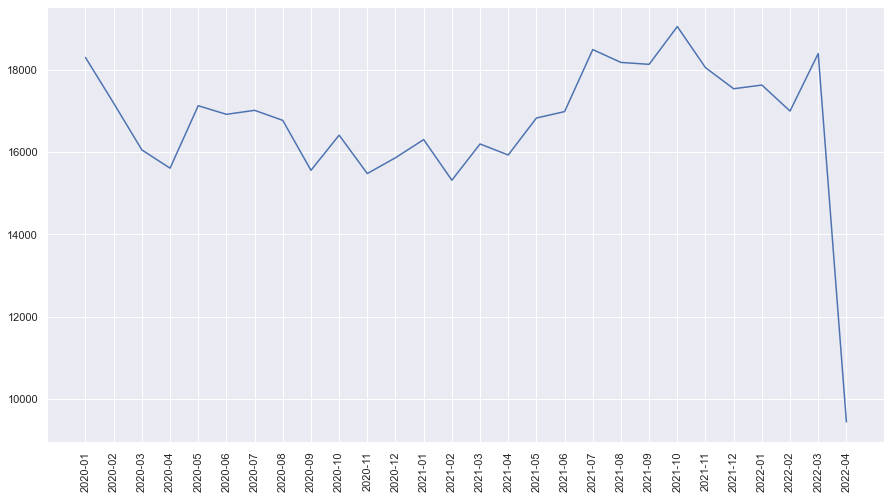

In [12]:
#PLOT 1 ---- TOTAL CRIMES VS MONTH-YEAR

mon_yr_X = df_date['yr_mon'].value_counts().sort_index().index
mon_yr_Y = df_date['yr_mon'].value_counts().sort_index().values

plot1 = sns.lineplot(x = mon_yr_X,
                     y = mon_yr_Y )
plt.setp(plot1.get_xticklabels(), rotation=90)
plt.show()

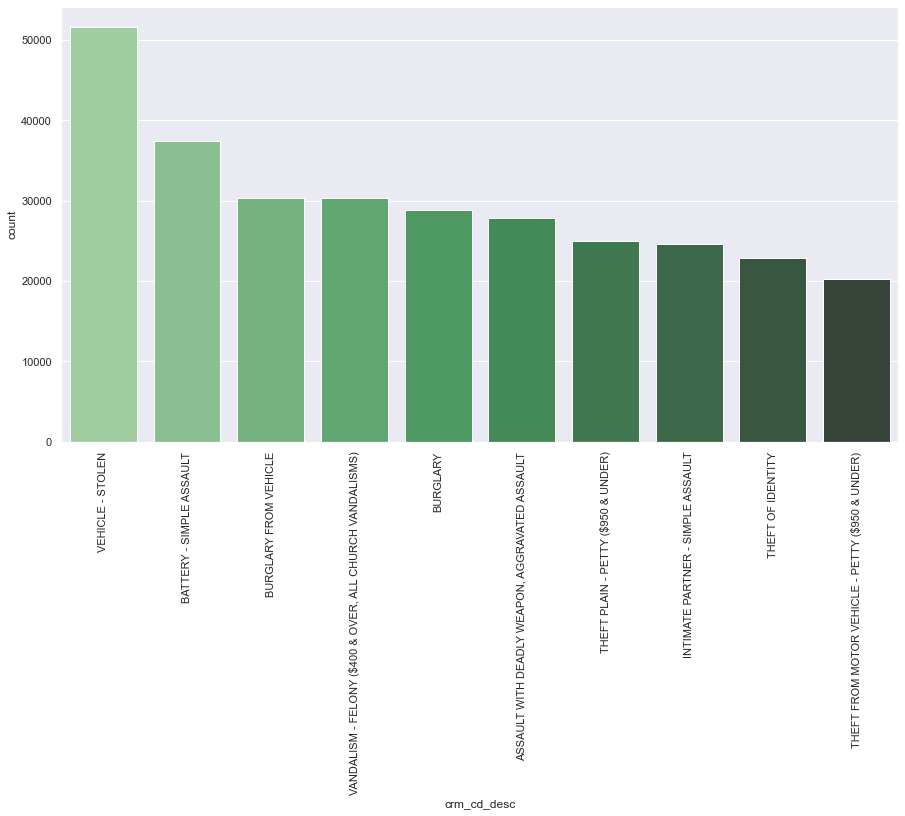

In [13]:
#PLOT 2 ---- COUNT top 10 crimes
top_10_crime =  results_df['crm_cd_desc'].value_counts().iloc[:10].index
plot2 = sns.countplot(data= results_df, 
              x='crm_cd_desc',
              palette="Greens_d",
              order = top_10_crime)
plt.setp(plot2.get_xticklabels(), rotation=90)
plt.show()

In [67]:
# top 10 crimes in Los Angels County
top_10_crime

Index(['VEHICLE - STOLEN', 'BATTERY - SIMPLE ASSAULT',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'BURGLARY FROM VEHICLE', 'BURGLARY',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'INTIMATE PARTNER - SIMPLE ASSAULT', 'THEFT OF IDENTITY',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)'],
      dtype='object')

In [127]:
# count crimes in area
results_df['area_name'].value_counts()

77th Street    28674
Central        27766
Pacific        26892
Southwest      24784
Hollywood      24542
Southeast      23202
N Hollywood    23025
Olympic        22557
Newton         22011
West LA        20980
Wilshire       20957
Rampart        20498
Northeast      19582
Harbor         19405
Van Nuys       19068
Mission        18472
West Valley    18312
Topanga        18242
Devonshire     17833
Hollenbeck     17308
Foothill       15520
Name: area_name, dtype: int64

In [15]:
gis = GIS("http://www.arcgis.com", "darknight22", "godblessme666")

In [16]:
# Function to find zip codes by longitude and latitude
def get_zip(df, lon_field, lat_field):
    location = reverse_geocode((Geometry({"x":float(df[lon_field]), 
                                          "y":float(df[lat_field]), 
                                          "spatialReference":{"wkid": 4326}})))
    return location['address']['Postal']

In [17]:
# Find the zip codes of related crimes in April 2022. 

yyyy_mm = '2022-04'
df_mon = df_date[df_date['yr_mon'] == yyyy_mm]
zipcodes = df_mon.apply(get_zip, axis=1, lat_field='lat', lon_field='lon')
zipcodes

433988    91335
444476    90059
454284    90031
434728    90002
429149    90039
          ...  
466123    90028
427157    90025
437244    90047
451238    90013
422529    90024
Length: 9445, dtype: object

In [18]:
df_mon.insert(5,'zip_codes',zipcodes)
df_mon

,dr_no,date_rptd,date_occ,yr_mon,time_occ,zip_codes,area,area_name,rpt_dist_no,part_1_2,...,status,status_desc,crm_cd_1,location,lat,lon,crm_cd_2,cross_street,crm_cd_3,crm_cd_4
433988,221008086,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,2022-04,0700,91335,10,West Valley,1025,2,...,IC,Invest Cont,624,6900 JAMIESON AV,34.1962,-118.5216,NaN,NaN,NaN,NaN
444476,221809363,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,2022-04,0830,90059,18,Southeast,1849,1,...,IC,Invest Cont,230,WILMINGTON,33.9295,-118.2391,NaN,IMPERIAL,NaN,NaN
454284,220407651,2022-04-18T00:00:00.000,2022-04-15T00:00:00.000,2022-04,1700,90031,04,Hollenbeck,0411,1,...,IC,Invest Cont,331,400 SAN FERNANDO RD,34.0787,-118.224,NaN,NaN,NaN,NaN
434728,221809380,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,2022-04,1900,90002,18,Southeast,1826,1,...,IC,Invest Cont,310,1600 E 103RD ST,33.9485,-118.2461,NaN,NaN,NaN,NaN
429149,221108036,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,2022-04,0935,90039,11,Northeast,1146,1,...,IC,Invest Cont,510,2900 N COOLIDGE AV,34.1029,-118.2462,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466123,220608261,2022-04-03T00:00:00.000,2022-04-03T00:00:00.000,2022-04,0600,90028,06,Hollywood,0648,1,...,IC,Invest Cont,510,1600 N WILTON PL,34.1001,-118.3136,NaN,NaN,NaN,NaN
427157,220807962,2022-04-03T00:00:00.000,2022-03-28T00:00:00.000,2022-04,2330,90025,08,West LA,0835,1,...,IC,Invest Cont,440,WESTWOOD,34.0497,-118.4368,NaN,SANTA MONICA,NaN,NaN
437244,221209196,2022-04-03T00:00:00.000,2022-04-03T00:00:00.000,2022-04,1800,90047,12,77th Street,1263,1,...,IC,Invest Cont,230,1600 W 84TH ST,33.9627,-118.3047,NaN,NaN,NaN,NaN
451238,220109516,2022-04-03T00:00:00.000,2022-03-31T00:00:00.000,2022-04,2344,90013,01,Central,0154,2,...,IC,Invest Cont,740,500 S SPRING ST,34.0474,-118.2496,NaN,NaN,NaN,NaN


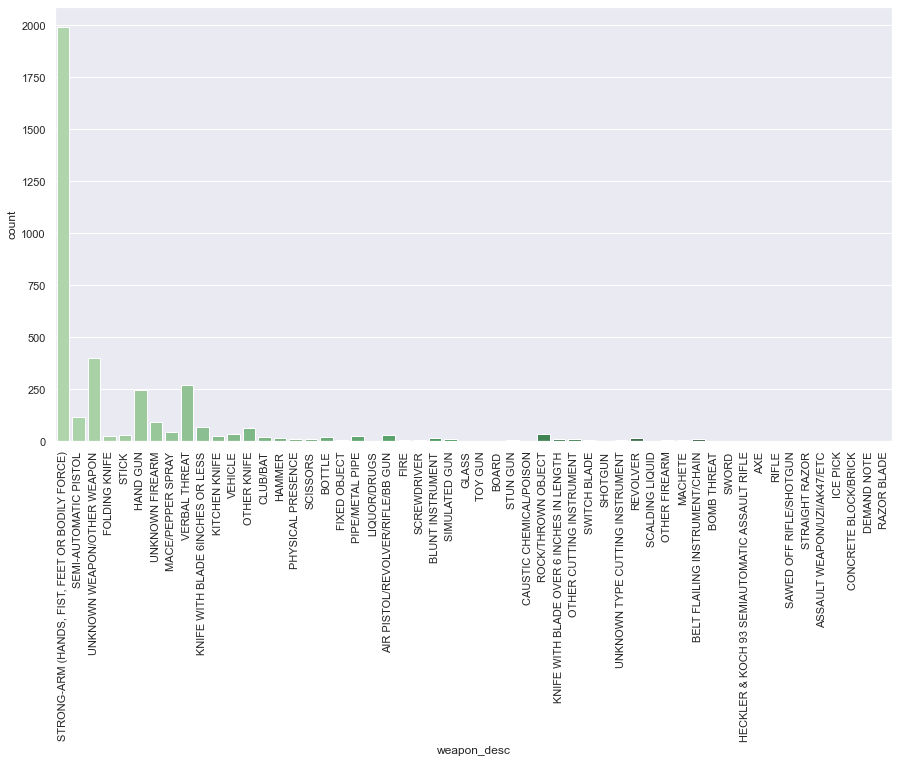

In [221]:
#Plot 3 ---- Weaponized or not
plot3 = sns.countplot(data= df_mon, 
              x='weapon_desc',
              palette="Greens_d")
plt.setp(plot3.get_xticklabels(), rotation=90)
plt.show()

In [19]:
df_mon['crm_cd_desc'].unique()

array(['BATTERY - SIMPLE ASSAULT',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 'BURGLARY',
       'VEHICLE - STOLEN', 'BIKE - STOLEN',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED',
       'INTIMATE PARTNER - SIMPLE ASSAULT', 'THEFT OF IDENTITY',
       'BURGLARY FROM VEHICLE',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'ROBBERY',
       'OTHER MISCELLANEOUS CRIME',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'VIOLATION OF COURT ORDER', 'DOCUMENT FORGERY / STOLEN FELONY',
       'BUNCO, GRAND THEFT',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'BATTERY WITH SEXUAL CONTACT', 'CRIMINAL HOMICIDE',
       'ATTEMPTED ROBBERY', 'CONTEMPT OF COURT',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'VEHICLE - MOTORIZED SCOOTERS, BICYCLES, AND WHEELCHAIRS',
       'THEFT, PERSON', 'VIOLATIO

In [20]:
# DELETING ALL THESE NON RELATED CRIMES:

# 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD'
# 'VIOLATION OF TEMPORARY RESTRAINING ORDER'
# 'CONTEMPT OF COURT'
# 'CRUELTY TO ANIMALS'
# 'UNAUTHORIZED COMPUTER ACCESS'
# 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT'
# 'VEHICLE - MOTORIZED SCOOTERS, BICYCLES, AND WHEELCHAIRS'
# 'FALSE IMPRISONMENT'
# 'DRIVING WITHOUT OWNER CONSENT (DWOC)'
# 'CREDIT CARDS, FRAUD USE ($950.01 & OVER)'
# 'CREDIT CARDS, FRAUD USE ($950 & UNDER'
# 'PIMPING'
# 'COUNTERFEIT'
# 'BUNCO, ATTEMPT'
# 'BOAT - STOLEN'
# 'CHILD ABANDONMENT'
# 'FALSE POLICE REPORT'

df_crime = df_mon.loc[((df_mon['crm_cd_desc'] != 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD') &
                      (df_mon['crm_cd_desc'] != 'VIOLATION OF TEMPORARY RESTRAINING ORDER') &
                      (df_mon['crm_cd_desc'] != 'CONTEMPT OF COURT') &
                      (df_mon['crm_cd_desc'] != 'CRUELTY TO ANIMALS') &
                      (df_mon['crm_cd_desc'] != 'UNAUTHORIZED COMPUTER ACCESS') &
                      (df_mon['crm_cd_desc'] != 'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT') &
                      (df_mon['crm_cd_desc'] != 'VEHICLE - MOTORIZED SCOOTERS, BICYCLES, AND WHEELCHAIRS') &
                      (df_mon['crm_cd_desc'] != 'FALSE IMPRISONMENT') &
                      (df_mon['crm_cd_desc'] != 'DRIVING WITHOUT OWNER CONSENT (DWOC)') &
                      (df_mon['crm_cd_desc'] != 'CREDIT CARDS, FRAUD USE ($950.01 & OVER)') &
                      (df_mon['crm_cd_desc'] != 'CREDIT CARDS, FRAUD USE ($950 & UNDER') &
                      (df_mon['crm_cd_desc'] != 'PIMPING') &
                      (df_mon['crm_cd_desc'] != 'COUNTERFEIT') &
                      (df_mon['crm_cd_desc'] != 'BUNCO, ATTEMPT') &
                      (df_mon['crm_cd_desc'] != 'BOAT - STOLEN') &
                      (df_mon['crm_cd_desc'] != 'CHILD ABANDONMENT') &
                      (df_mon['crm_cd_desc'] != 'FALSE POLICE REPORT')
                      )]

In [21]:
#Insert Days in month to database
Days = []
for i in range(len(df_crime)):
    Days.append(datetime.fromisoformat(df_crime['date_occ'].iloc[i]).day)

df_crime.insert(1,'Days_of_Mon',Days)

In [34]:
mon = []
for i in range(len(df_crime)):
    mon.append(datetime.fromisoformat(df_crime['date_occ'].iloc[i]).month)
df_crime.insert(1,'Mon',mon)

In [37]:
df_crime

,dr_no,Mon,Days_of_Mon,date_rptd,date_occ,yr_mon,time_occ,zip_codes,area,area_name,...,status,status_desc,crm_cd_1,location,lat,lon,crm_cd_2,cross_street,crm_cd_3,crm_cd_4
433988,221008086,4,17,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,2022-04,0700,91335,10,West Valley,...,IC,Invest Cont,624,6900 JAMIESON AV,34.1962,-118.5216,NaN,NaN,NaN,NaN
444476,221809363,4,18,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,2022-04,0830,90059,18,Southeast,...,IC,Invest Cont,230,WILMINGTON,33.9295,-118.2391,NaN,IMPERIAL,NaN,NaN
454284,220407651,4,15,2022-04-18T00:00:00.000,2022-04-15T00:00:00.000,2022-04,1700,90031,04,Hollenbeck,...,IC,Invest Cont,331,400 SAN FERNANDO RD,34.0787,-118.224,NaN,NaN,NaN,NaN
434728,221809380,4,17,2022-04-18T00:00:00.000,2022-04-17T00:00:00.000,2022-04,1900,90002,18,Southeast,...,IC,Invest Cont,310,1600 E 103RD ST,33.9485,-118.2461,NaN,NaN,NaN,NaN
429149,221108036,4,18,2022-04-18T00:00:00.000,2022-04-18T00:00:00.000,2022-04,0935,90039,11,Northeast,...,IC,Invest Cont,510,2900 N COOLIDGE AV,34.1029,-118.2462,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466123,220608261,4,3,2022-04-03T00:00:00.000,2022-04-03T00:00:00.000,2022-04,0600,90028,06,Hollywood,...,IC,Invest Cont,510,1600 N WILTON PL,34.1001,-118.3136,NaN,NaN,NaN,NaN
427157,220807962,3,28,2022-04-03T00:00:00.000,2022-03-28T00:00:00.000,2022-04,2330,90025,08,West LA,...,IC,Invest Cont,440,WESTWOOD,34.0497,-118.4368,NaN,SANTA MONICA,NaN,NaN
437244,221209196,4,3,2022-04-03T00:00:00.000,2022-04-03T00:00:00.000,2022-04,1800,90047,12,77th Street,...,IC,Invest Cont,230,1600 W 84TH ST,33.9627,-118.3047,NaN,NaN,NaN,NaN
451238,220109516,3,31,2022-04-03T00:00:00.000,2022-03-31T00:00:00.000,2022-04,2344,90013,01,Central,...,IC,Invest Cont,740,500 S SPRING ST,34.0474,-118.2496,NaN,NaN,NaN,NaN


In [41]:
# Build up the database
df_crime = df_crime[df_crime.loc[:,'Mon']==4]
db_crime = df_crime.loc[:,['dr_no','Days_of_Mon','time_occ','area_name','zip_codes','crm_cd_desc','weapon_desc']]
db_crime.index = range(len(db_crime))
db_crime.columns = ['Case_No','Days_of_Mon','Time_occured(24hr)','Areas','Zip_Codes','Crimes','Weapons']

#Transform to Json format
db_json = db_crime.to_json(orient = 'index')
db_crime

,Case_No,Days_of_Mon,Time_occured(24hr),Areas,Zip_Codes,Crimes,Weapons
0,221008086,17,0700,West Valley,91335,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
1,221809363,18,0830,Southeast,90059,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",UNKNOWN WEAPON/OTHER WEAPON
2,220407651,15,1700,Hollenbeck,90031,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,NaN
3,221809380,17,1900,Southeast,90002,BURGLARY,UNKNOWN WEAPON/OTHER WEAPON
4,221108036,18,0935,Northeast,90039,VEHICLE - STOLEN,NaN
...,...,...,...,...,...,...,...
8209,221107472,3,1330,Northeast,90026,BATTERY - SIMPLE ASSAULT,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
8210,220200663,3,0210,Rampart,90057,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",HAND GUN
8211,220608261,3,0600,Hollywood,90028,VEHICLE - STOLEN,NaN
8212,221209196,3,1800,77th Street,90047,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",SEMI-AUTOMATIC PISTOL


In [42]:
# Total Types of Crimes
len(db_crime['Crimes'].unique())

83

In [45]:
#db_crime.to_csv('safetyLA_Apr.csv')

Creating new Database 

In [106]:
safe = pd.read_csv('safety_index.csv',index_col=0)
safe = safe[['Areas','safety_index']]
safe

,Areas,safety_index
0,77th Street,83.120453
1,Central,32.145211
2,Devonshire,94.589569
3,Foothill,94.708747
4,Harbor,92.181660
5,Hollenbeck,93.132865
6,Hollywood,56.655272
7,Mission,92.508506
8,N Hollywood,86.815167
9,Newton,74.289315


In [112]:
def find_areas(df):
    Areas_df = pd.DataFrame({'Areas':[],'Zip_Codes':[]})
    Areas_df['Zip_Codes'] = Areas_df['Zip_Codes'].astype('object')
    areas = df['Areas'].unique()
    i = 0
    for area in areas:
        zips = np.array(df[df['Areas'] == area]['Zip_Codes'].unique())
        Areas_df.loc[i,'Areas'] = area
        Areas_df.at[i,'Zip_Codes'] = zips
        i = i+1
    return(Areas_df)

In [130]:
Areas_db = find_areas(db_crime)
Areas_db

,Areas,Zip_Codes
0,West Valley,"[91335, 91356, 91316, 91406, 91436, 91325, 913..."
1,Southeast,"[90059, 90002, 90044, 90003, 90061, 90247, 900..."
2,Hollenbeck,"[90031, 90023, 90032, 90033, 90042, 90063]"
3,Northeast,"[90039, 90041, 90029, 90026, 90027, 90065, 900..."
4,Harbor,"[90731, 90710, 90744, 90732, 90502, 90248, 905..."
5,Southwest,"[90037, 90016, 90008, 90018, 90007, 90089, 900..."
6,Wilshire,"[90019, 90048, 90069, 90046, 90035, 90036, 900..."
7,Central,"[90015, 90012, 90017, 90014, 90021, 90013, 900..."
8,Foothill,"[91331, 91605, 91042, 91040, 91352, 91340, 913..."
9,Pacific,"[90245, 90291, 90066, 90293, 90034, 90232, 900..."


In [131]:
Areas_db = Areas_db.merge(safe,left_on = 'Areas',right_on = 'Areas') #merege the data
Areas_db = Areas_db.rename(columns={"safety_index":'Safety_Index'}) #rename the safety index columns
Areas_db['Safety_Index'] = Areas_db['Safety_Index'].round(1)
areas_json = Areas_db.to_json(orient = 'index') #transform to json
Areas_db

,Areas,Zip_Codes,Safety_Index
0,West Valley,"[91335, 91356, 91316, 91406, 91436, 91325, 913...",83.5
1,Southeast,"[90059, 90002, 90044, 90003, 90061, 90247, 900...",85.6
2,Hollenbeck,"[90031, 90023, 90032, 90033, 90042, 90063]",93.1
3,Northeast,"[90039, 90041, 90029, 90026, 90027, 90065, 900...",93.3
4,Harbor,"[90731, 90710, 90744, 90732, 90502, 90248, 905...",92.2
5,Southwest,"[90037, 90016, 90008, 90018, 90007, 90089, 900...",87.2
6,Wilshire,"[90019, 90048, 90069, 90046, 90035, 90036, 900...",89.7
7,Central,"[90015, 90012, 90017, 90014, 90021, 90013, 900...",32.1
8,Foothill,"[91331, 91605, 91042, 91040, 91352, 91340, 913...",94.7
9,Pacific,"[90245, 90291, 90066, 90293, 90034, 90232, 900...",93.1


In [142]:
crime = pd.read_csv('area_summary.csv')
crime.head()

,Areas,crime_class,crime_class.1
0,77th Street,Light Crime,16
1,77th Street,Medium Crime,357
2,77th Street,Severe Crime,151
3,Central,Light Crime,22
4,Central,Medium Crime,450


In [143]:
#In the New data frame crime_class, the second column is the counts of three lecel of crimes
#the first one is Light Crime
#the second one is Medium Crime
#the third one is Severe Crime
crime_class =crime.groupby('Areas')['crime_class.1'].apply(list).reset_index(name='Crime_Class')
crime_class 

,Areas,Crime_Class
0,77th Street,"[16, 357, 151]"
1,Central,"[22, 450, 265]"
2,Devonshire,"[9, 202, 57]"
3,Foothill,"[6, 177, 69]"
4,Harbor,"[21, 242, 90]"
5,Hollenbeck,"[19, 203, 58]"
6,Hollywood,"[7, 284, 95]"
7,Mission,"[25, 242, 61]"
8,N Hollywood,"[4, 238, 93]"
9,Newton,"[19, 311, 100]"


In [138]:
Areas_db = Areas_db.merge(crime_class,left_on = 'Areas',right_on = 'Areas')
Areas_db

,Areas,Zip_Codes,Safety_Index,Crime_Class
0,West Valley,"[91335, 91356, 91316, 91406, 91436, 91325, 913...",83.5,"[13, 250, 113]"
1,Southeast,"[90059, 90002, 90044, 90003, 90061, 90247, 900...",85.6,"[12, 314, 140]"
2,Hollenbeck,"[90031, 90023, 90032, 90033, 90042, 90063]",93.1,"[19, 203, 58]"
3,Northeast,"[90039, 90041, 90029, 90026, 90027, 90065, 900...",93.3,"[16, 278, 93]"
4,Harbor,"[90731, 90710, 90744, 90732, 90502, 90248, 905...",92.2,"[21, 242, 90]"
5,Southwest,"[90037, 90016, 90008, 90018, 90007, 90089, 900...",87.2,"[18, 346, 117]"
6,Wilshire,"[90019, 90048, 90069, 90046, 90035, 90036, 900...",89.7,"[12, 294, 88]"
7,Central,"[90015, 90012, 90017, 90014, 90021, 90013, 900...",32.1,"[22, 450, 265]"
8,Foothill,"[91331, 91605, 91042, 91040, 91352, 91340, 913...",94.7,"[6, 177, 69]"
9,Pacific,"[90245, 90291, 90066, 90293, 90034, 90232, 900...",93.1,"[18, 313, 118]"


In [139]:
areas_json = Areas_db.to_json(orient = 'index') #transform to json

In [89]:
# Download the areas csv

#Areas_db.to_csv('Areas_APR.csv')

In [141]:
#Upload data to Firebase 

#requests.put("https://safety-la-apr-default-rtdb.firebaseio.com/areas.json",data = areas_json)


# Function to delete ALL data in database 

#requests.delete("https://safety-la-apr-default-rtdb.firebaseio.com/areas.json")

<Response [200]>